In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")
import sys
import os
sys.path.append(os.path.abspath("./compress_native/cmake-build-debug/"))

In [2]:
font_size = 7

In [122]:
from solvers import hr_grid_forward_step_size_independent_1d, uw_grid_forward_step_size_independent_1d, pa_forward_step 
from solvers import agglomeration_grid_2d, agglomeration_pa_2d
from solvers import hr_grid_forward_step_size_independent_2d, uw_grid_forward_step_size_independent_2d
from solvers import hr_grid_forward_step_size_dependent_1d,uw_grid_forward_step_size_dependent_1d
from compress import compress, compress_scipy_1d
from solvers import agglomeration_grid_1d, agglomeration_pa_1d
from solvers import breakage_grid_1d, BreakageKernel, breakage_pa_1d, log_mean
from solvers import agglomeration_grid_2d, agglomeration_pa_2d
from solvers import breakage_pa_2d, breakage_grid_2d, DaughterGridType

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic, binned_statistic_2d, norm
import pandas as pd
import matplotlib
from time import perf_counter
from compress_binding import compress as compress_native

In [15]:
# Benchmarking class
class PerformanceLogger:
    def __init__(self):
        self.checkpoint = None
        self.time_points = []
        self.extras = []
    def before(self):
        self.checkpoint = perf_counter()
        
    def after(self, extra=None):
        self.time_points.append(perf_counter() - self.checkpoint)
        self.checkpoint = None
        self.extras.append(extra)    
        
    def to_dataframe(self):
        time_points_df = pd.DataFrame(data=self.time_points, columns=["time_elapsed"])
        extras_df = pd.DataFrame(data=self.extras)
        df = pd.concat([time_points_df, extras_df], axis=1)
        return df

def get_rolling_mean(logger, window):
    df = logger.to_dataframe().set_index("t")
    rolling = df.time_elapsed.rolling(window)
    mean = rolling.mean()
    return mean, df

# Growth and nucleation

## One dimensional pure growth

In [12]:
g = 1.0
dL = 1.0
dt = 0.1
t_total = 200
n_init = np.zeros((1000, ))
n_init[10:80] = 1
norm_part = norm.pdf(np.linspace(0, 300, n_init[400: 600].size), loc=200, scale=60)
norm_part /= norm_part.max()
n_init[400: 600] = norm_part

L_edges = np.arange(0, n_init.size+1, dL)
L = 0.5*(L_edges[1:] + L_edges[:-1])

n_hr = n_init.copy()
n_uw = n_init.copy()
n_pa = np.vstack((L, n_init)).T
n_pa = n_pa[n_init > 0]

hr_logger = PerformanceLogger()
pa_logger = PerformanceLogger()
uw_logger = PerformanceLogger()

for t in np.arange(0, t_total, dt):
    hr_logger.before()
    n_hr = hr_grid_forward_step_size_independent_1d(n_hr, dL, dt, g)
    hr_logger.after({"t": t})
    
    uw_logger.before()
    n_uw = uw_grid_forward_step_size_independent_1d(n_uw, dL, dt, g)
    uw_logger.after({"t": t})
    
    pa_logger.before()
    n_pa = pa_forward_step(n_pa, dt, g)
    pa_logger.after(extra={"nrows": n_pa.shape[0], "t": t})

HR Mean: 1.891199999994342e-05
UW Mean: 3.211599998849124e-06
PA Mean: 1.3882400001193674e-05


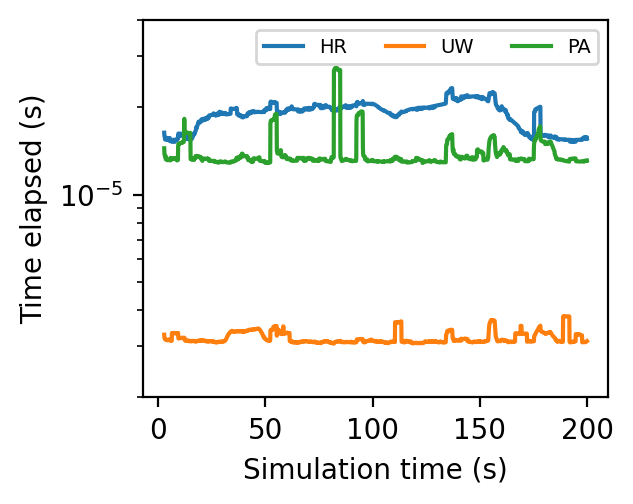

In [16]:
# Visualize the results
rolling_window = 30
sigma = 2

hr_rmean, hr_df = get_rolling_mean(hr_logger, rolling_window)
uw_rmean, uw_df = get_rolling_mean(uw_logger, rolling_window)
pa_rmean, pa_df = get_rolling_mean(pa_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(uw_rmean, color="C1", label="UW")
ax.plot(pa_rmean, color="C2", label="PA")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([2e-6, 4e-5])
save_fig(fig, "1d_pure_growth_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"UW Mean: {uw_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")


## One dimensional growth and nucleation

In [18]:
B = 1e5 # #/m3/s
g =0.7
dL = 1.0
dt = 0.01
t_total = 200.
n_init = np.zeros((400, ))

L_edges = np.arange(0, n_init.size+1, dL)
L = 0.5*(L_edges[1:] + L_edges[:-1])

n_hr = n_init.copy()
n_uw = n_init.copy()
N_pa = np.array([]).reshape((0, 2))
N_pa_compress = np.array([]).reshape((0, 2))

uw_logger = PerformanceLogger()
hr_logger = PerformanceLogger()
pa_logger = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()


t = 0
while t < t_total:

    dt_ = min(dt, t_total - t)

    hr_logger.before()    
    n_hr[0] += B * dt / dL
    n_hr = hr_grid_forward_step_size_independent_1d(n_hr, dL, dt_, g)
    hr_logger.after(extra={"t": t})
    
    uw_logger.before() 
    n_uw[0] += B * dt / dL
    n_uw = uw_grid_forward_step_size_independent_1d(n_uw, dL, dt_, g)
    uw_logger.after(extra={"t": t})
    
    pa_logger.before() 
    N_pa = np.vstack([N_pa, np.array((0., B * dt))])
    N_pa = pa_forward_step(N_pa, dt_, g)
    pa_logger.after(extra={"t": t, "nrows": N_pa.shape[0]})
    
    pac_logger.before()
    N_pa_compress = np.vstack([N_pa_compress, np.array((0., B * dt))])
    N_pa_compress = pa_forward_step(N_pa_compress, dt_, g)
    
    compress_logger.before()
    nrows_before = N_pa_compress.shape[0]
    N_pa_compress = compress_native(N_pa_compress, 1.0, np.array([3.0]), 1.0, False)
    nrows_after = N_pa_compress.shape[0]
    compress_logger.after(extra={"t": t, "nrows_before": nrows_before, "nrows_after": nrows_after})
    
    pac_logger.after(extra={"t": t, "nrows": N_pa_compress.shape[0]})

    t += dt_
    

HR Mean: 1.1505229738400994e-05
UW Mean: 3.350732463005459e-06
PA Mean: 3.905105744699472e-05


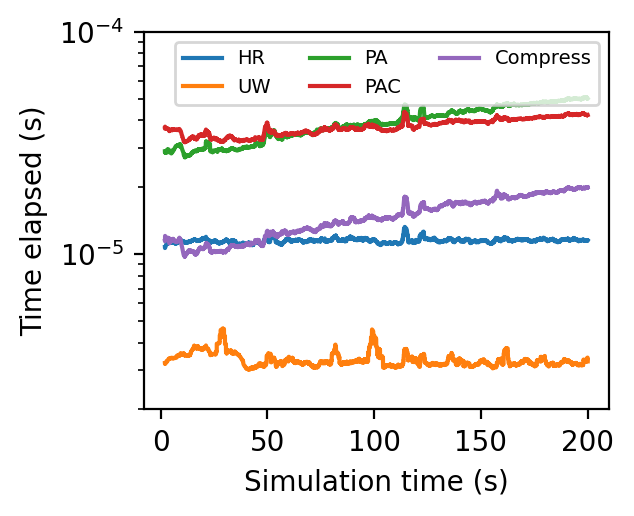

In [19]:
# Visualize the results
rolling_window = 200
sigma = 2

hr_rmean, hr_df = get_rolling_mean(hr_logger, rolling_window)
uw_rmean, uw_df = get_rolling_mean(uw_logger, rolling_window)
pa_rmean, pa_df = get_rolling_mean(pa_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
time_range = (hr_df.index[0], hr_df.index[-1])

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(uw_rmean, color="C1", label="UW")
ax.plot(pa_rmean, color="C2", label="PA")
ax.plot(pac_rmean, color="C3", label="PAC")
ax.plot(c_rmean, color="C4", label="Compress")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([2e-6, 1e-4])
save_fig(fig, "1d_nucleation_growth_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"UW Mean: {uw_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

## 2D pure growth

In [21]:
gs_pa = np.array([1.2, 0.3])
gs_uw = np.array([0.3, 1.2])
gs_hr = np.array([0.78, 0.78])
dL = 1.0
dt = 0.5
t_total = 400
n_init = np.zeros((800, 800))
n_init[100:250, 100:250] = 1

L_edges = [np.arange(0, sz+1, dL) for sz in n_init.shape]
L_edges_meshgrid = np.meshgrid(*L_edges)
L_centers = [0.5*(e[:-1] + e[1:]) for e in L_edges]
L_centers_meshgrid = np.meshgrid(*L_centers)

uw_logger = PerformanceLogger()
hr_logger = PerformanceLogger()
pa_logger = PerformanceLogger()

n_hr = n_init.copy()
n_uw = n_init.copy()
n_pa = np.vstack((L_centers_meshgrid[0].reshape(-1), L_centers_meshgrid[1].reshape(-1), n_init.reshape(-1))).T
n_pa = n_pa[n_pa[:, -1] > 0]
n_pa_init = n_pa.copy()

for t in np.arange(0, t_total, dt):
    hr_logger.before()
    n_hr = hr_grid_forward_step_size_independent_2d(n_hr, dL, dt, gs_hr)
    hr_logger.after(extra={"t": t})
    
    uw_logger.before()
    n_uw = uw_grid_forward_step_size_independent_2d(n_uw, dL, dt, gs_uw)
    uw_logger.after(extra={"t": t})
    
    pa_logger.before()
    n_pa = pa_forward_step(n_pa, dt, gs_pa)
    pa_logger.after(extra={"t": t, "nrows": N_pa.shape[0]})

HR Mean: 0.02320256424999826
UW Mean: 0.004483514874999059
PA Mean: 0.0003927782499980026


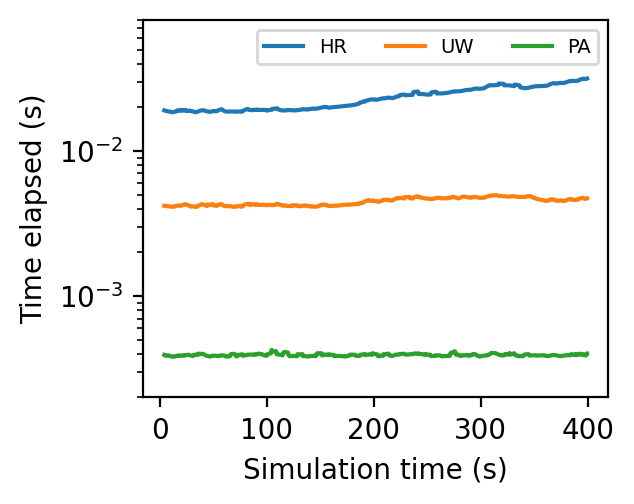

In [22]:
# Visualize the results
rolling_window = 10
sigma = 2

hr_rmean, hr_df = get_rolling_mean(hr_logger, rolling_window)
uw_rmean, uw_df = get_rolling_mean(uw_logger, rolling_window)
pa_rmean, pa_df = get_rolling_mean(pa_logger, rolling_window)


fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(uw_rmean, color="C1", label="UW")
ax.plot(pa_rmean, color="C2", label="PA")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.2e-3, 8e-2])
save_fig(fig, "2d_pure_growth_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"UW Mean: {uw_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

## 1D size dependent growth

In [23]:
g =0.1
dv = 1e-4
dt = 1e-4
t_total = 5
N_0 = 1.0
v_0 = 0.01

v_edges = np.arange(1e-4, 1, dv)
v = 0.5*(v_edges[1:] + v_edges[:-1])

n_init = N_0 / v_0 * np.exp(-v/v_0)
n_analytical_final = N_0 / v_0 * np.exp(-v/v_0*np.exp(-g*t_total) - g*t_total)
n_hr = n_init.copy()
n_uw = n_init.copy()

N_pa = np.vstack((v, n_init.copy())).T
N_pa = N_pa[N_pa[:, 1] >= 1e-8]
N_pa_init = N_pa.copy()

N_pa_cnt = N_pa_init.copy()
N_pa_cnt[:, -1] *= dv

uw_logger = PerformanceLogger()
hr_logger = PerformanceLogger()
pa_logger = PerformanceLogger()

t = 0
G = v * g
while t < t_total:

    dt_ = min(dt, t_total - t)
    
    hr_logger.before()
    n_hr = hr_grid_forward_step_size_dependent_1d(n_hr, dv, dt_, G)
    hr_logger.after(extra={"t": t})
    
    uw_logger.before()
    n_uw = uw_grid_forward_step_size_dependent_1d(n_uw, dv, dt_, G)
    uw_logger.after(extra={"t": t})
    
    pa_logger.before()
    N_pa_cnt = pa_forward_step(N_pa_cnt, dt_, np.expand_dims(N_pa_cnt[:, 0], 1) * g)
    pa_logger.after(extra={"t": t, "nrows": N_pa.shape[0]})
    t += dt_


HR Mean: 0.00014951652799943303
UW Mean: 4.286083999972561e-05
PA Mean: 3.62557219994892e-05


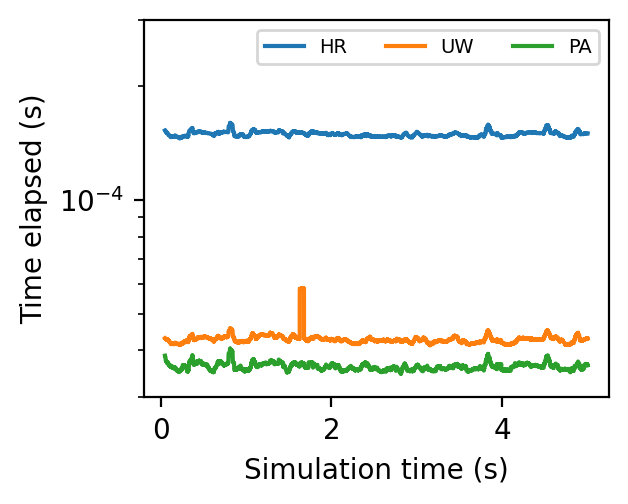

In [24]:
# Visualize the results
rolling_window = 500
sigma = 2
hr_rmean, hr_df = get_rolling_mean(hr_logger, rolling_window)
uw_rmean, uw_df = get_rolling_mean(uw_logger, rolling_window)
pa_rmean, pa_df = get_rolling_mean(pa_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(uw_rmean, color="C1", label="UW")
ax.plot(pa_rmean, color="C2", label="PA")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([3e-5, 3e-4])
save_fig(fig, "1d_size_dependent_growth_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"UW Mean: {uw_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

# Continuous Crystallization

In [38]:
def solubility(T):
    return 1.721e-4 * T ** 2 - 5.88e-3 * T + 0.1286

def T_profile(t):
    return 32-4*(1-np.exp(-t/18600))

def birth_rate(T, c, v):
    kb = 4.64e-7 * 1000
    b = 1.78
    sol = solubility(T)
    if c > sol:
        B = kb * ((c - sol) / sol) ** b
    else:
        B = 0.
    return B

def growth_rate(T, c, L, beta=0.):
    kg = 1.16e2
    g = 1.32
    sol = solubility(T)
    G = kg * ((c - sol) / sol) ** g * (1 + beta*L)
    return G

density = 2.11e-12 # g/um3

dL = 0.2
L_edges = np.arange(0, 1000, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
non_zero_idx = (L_centers >= 180.5) & (L_centers <= 210.5)
L_non_zero = L_centers[non_zero_idx]
n_init[non_zero_idx] = -3.48e-4 * L_non_zero ** 2 + 0.136 * L_non_zero - 13.21
T_init = T_profile(0)
c_init = solubility(T_init)
v_init = trapz(n_init * L_centers ** 3, L_centers)

growth_fcn = hr_grid_forward_step_size_dependent_1d
residence_time = 100
t_total = 3000
T = 31.5
time_step_scale = 0.5

dt_max = 1
beta = 0.01

In [39]:
%%functionize single_stage_simulation -a growth_fcn beta time_step_scale -r logger --skip
n = n_init.copy()

c = c_init

v = trapz(n * L_centers**3, L_centers)

t = 0

logger = PerformanceLogger()

while t < t_total:
    logger.before()
    G = growth_rate(T, c, L_centers, beta)
    B = birth_rate(T, c, v)


    # compute time step
    dt = dL / np.max(G)
    dt = np.min([dt, dt_max]) * time_step_scale
    dt = np.min([dt, t_total-t])
    # Update nucleation
    n[0] += B * dt / dL

    # Update growth
    n = growth_fcn(n, dL, dt, G)

    # Update concentration
    v_new = trapz(n * L_centers ** 3, L_centers)
    c -= (v_new - v) * density
    v = v_new

    # Update continuous
    c_in = c_init
    n_in = 0

    c += (c_in - c) * dt / residence_time
    n += (n_in - n) * dt / residence_time

    t += dt
    logger.after({"t": t})



In [40]:
hr_pos_logger = single_stage_simulation(hr_grid_forward_step_size_dependent_1d, 0.0005, time_step_scale)
uw_pos_logger = single_stage_simulation(uw_grid_forward_step_size_dependent_1d, 0.0005, time_step_scale)

In [50]:
%%functionize single_stage_simulation_pac -a beta time_step_scale -r logger logger_compress --skip

# PAC
n_pac = n_init.copy()
N_pac = np.vstack([L_centers, n_pac * dL]).T
N_pac = N_pac[N_pac[:, -1] > 0]
t = 0

c = c_init
v = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()

logger = PerformanceLogger()
logger_compress = PerformanceLogger()

while t < t_total:
    logger.before()
    G = growth_rate(T, c, N_pac[:, 0], beta)
    B = birth_rate(T, c, v)
    
    # compute time step
    dt = dL / np.max(G) * time_step_scale
    dt = np.min([dt, dt_max])
    dt = np.min([dt, t_total-t])
#     dt =1##################
    
    # Update nucleation
    if B != 0:
        N_pac = np.vstack([N_pac, np.array([0, B * dt])])

        # recalculate due to the new row
        G = growth_rate(T, c, N_pac[:, 0], beta)
    
    # Update growth
    # N_pa = pa_forward_step(N_pa, dt, np.expand_dims(G, 1))
    N_pac[:, 0] += G * dt
    # Update concentration
    v_new = (N_pac[:, 0] ** 3 * N_pac[:, -1]).sum()
    c -= (v_new - v) * density
    v = v_new
    
    # Update continuous
    c_in = c_init

    c += (c_in - c) * dt / residence_time
    N_pac[:, -1] += -N_pac[:, -1] * dt / residence_time
    logger_compress.before()
    if N_pac.shape[0] > 3000:
        N_pac = compress_native(N_pac, 1.0, np.array([3.0]), 1.0, False)
    logger_compress.after({"t": t})
        
#     N_pac = N_pac[N_pac[:, 0] < 1000] # remove out of grid objects
    N_pac = N_pac[N_pac[:, -1] > 1e-15]
    t += dt
    logger.after({"t": t})


In [51]:
pac_pos_logger, pac_pos_compress_logger = single_stage_simulation_pac(0.0005, time_step_scale)

HR Mean: 0.00035034350605475043
PA Mean: 3.62557219994892e-05


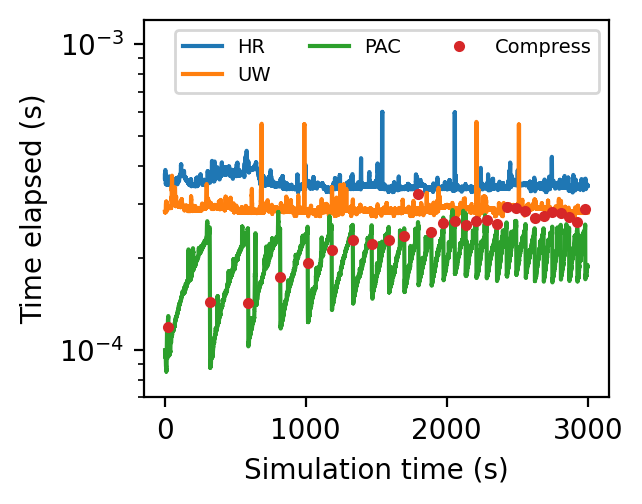

In [55]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

hr_rmean, hr_df = get_rolling_mean(hr_pos_logger, rolling_window)
uw_rmean, uw_df = get_rolling_mean(uw_pos_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_pos_logger, rolling_window)

c_df = pac_pos_compress_logger.to_dataframe().set_index("t")
c_time = c_df.time_elapsed
c_rmean = c_time.loc[c_time > 1e-4]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(uw_rmean, color="C1", label="UW")
ax.plot(pac_rmean, color="C2", label="PAC")
ax.plot(c_rmean, "C3.", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.7e-4, 12e-4])
save_fig(fig, "continuous_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

# Polymorphic transformation

In [142]:
%%functionize polymorphic_transformation_profiling -a kd -r pa_logger hr_logger --skip
def solubility(T):
    s_a = 8.437e-3 * T**2 - 0.03032 * T + 4.564
    s_b = 7.644e-3 * T**2 - 0.1165 * T + 6.622
    return s_a/1000, s_b/1000

def supersaturation(T, c):
    s_a, s_b = solubility(T)
    return c/s_a-1, c/s_b-1

def nucleation_rate(T, c, v, kbp=np.array([1e6, 1e5]), kbs = np.array([1e6, 1e5])):
    #/s/kg solvent
    b = 2
    
    sc = np.array(supersaturation(T, c))
    
    B = np.zeros((n_forms, ))
    for i, sc_ in enumerate(sc):
        if sc_ > 0:
            B[i] =  (kbp[i] + kbs[i] * v[i]/1e18) * sc_ ** b

    return B

def gd(T, c, kg, kd):
    g = 1
    d = 1
    
    sc = np.array(supersaturation(T, c))
    GD = np.zeros((n_forms, ))
    for i, sc_ in enumerate(sc):
        if sc_ > 0:
            GD[i] =  kg[i] * sc_ ** g
        elif sc_ < 0:
            GD[i] =  kd[i] * (-sc_) ** d
    return GD

density = 1540 * 1e-18 # kg solid/um3 solid
kshape = 0.48

dL = 0.5
L_edges = np.arange(0, 1000, dL)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])
n_init = np.zeros_like(L_centers)
T = 45
c_init = solubility(60)[0]
v_init = trapz(n_init * L_centers ** 3, L_centers)
growth_fcn = hr_grid_forward_step_size_independent_1d

t_total = 4000
dt_max = 30
n_forms = 2
kbp=np.array([1e6, 1e5])
kbs = np.array([1e6, 1e5])
dt_factor = 1.0
kg = np.array([0.1, 0.1])
# kd = np.array([-2.2, -2.2])
hr_logger = PerformanceLogger()
pa_logger = PerformanceLogger()

t = 0
c = c_init
v = np.array([0.,0.])

sol = solubility(T)

while t < t_total:
    hr_logger.before()
    sc = supersaturation(T, c)
    Gs = gd(T, c, kg, kd)
    Bs = nucleation_rate(T, c, v, kbp, kbs)
    
    # compute time step
    dt_G = dL / np.max(np.abs(Gs))
    # extra requirement: should not exceed the transformation line
    if np.prod(sc) < 0:
        # crossing
        dt_conc = np.inf
        with np.errstate(all='ignore'):
            # suppress divide by zero warning
            for i in range(n_forms):
                dt_conc = np.min([(c - sol[i]) / (3*density*kshape*Gs[i]*trapz(L_centers**2*ns[i], L_centers)), dt_conc])
            
    else:
        dt_conc = np.inf
    
    dt = np.min([dt_G, dt_conc]) * dt_factor
    dt = np.min([dt, t_total-t, dt_max])
    
    # Update nucleation
    for i in range(n_forms):
        if Bs[i] != 0:
            ns[i][0] += Bs[i] * dt / dL
    
    # Update growth
    for i in range(n_forms):
        ns[i] = growth_fcn(ns[i], dL, dt, Gs[i])

    
    # Update concentration
    for i in range(n_forms):
        # v: um3 solid / kg solvent
        v_new = trapz(ns[i] * L_centers ** 3, L_centers) * kshape # #/um/kg solvent * um^3 solid * um
        c -= (v_new - v[i]) * density # kg solute / kg solvent
        v[i] = v_new
    
    t += dt
    hr_logger.after(extra={"t": t, "dt": dt})


Ns = [np.array([]).reshape((0, 2))] * n_forms # #/um/kg solvent
t = 0
c = c_init
v = np.array([0.,0.])

sol = solubility(T)

while t < t_total:
    pa_logger.before()
    sc = supersaturation(T, c)
    Gs = gd(T, c, kg, kd)
    Bs = nucleation_rate(T, c, v, kbp, kbs)

    # compute time step
    dt_G = dL / np.max(np.abs(Gs))
    # extra requirement: should not exceed the transformation line
    if np.prod(sc) < 0:
        # crossing
        dt_conc = np.inf
        with np.errstate(all='ignore'):
            # suppress divide by zero warning
            for i in range(n_forms):
                dt_conc = np.min([(c - sol[i]) / (3*density*kshape*Gs[i]*(Ns[i][:, 0]**2 * Ns[i][:, 1]).sum()), dt_conc])

    else:
        dt_conc = np.inf

    dt = np.min([dt_G, dt_conc]) * dt_factor
    dt = np.min([dt, t_total-t, dt_max])

    # Update nucleation
    for i in range(n_forms):
        if Bs[i] != 0:
            new_row = np.array([[0, Bs[i] * dt]])
            Ns[i] = np.vstack([Ns[i], new_row])

    # Update growth
    for i in range(n_forms):
        Ns[i] = pa_forward_step(Ns[i], dt, Gs[i])


    # Update concentration
    for i in range(n_forms):
        # v: um3 solid / kg solvent
        N = Ns[i]
        v_new = (N[:, -1] * N[:, 0]**3).sum() * kshape # #/um/kg solvent * um^3 solid * um
        c -= (v_new - v[i]) * density # kg solute / kg solvent
        v[i] = v_new

    t += dt
    pa_logger.after(extra={"t": t, "nrows": N_pa.shape[0], "dt": dt})


In [174]:
pa_logger, hr_logger = polymorphic_transformation_profiling(kd=np.array([-1., -1.]))

HR Mean: 0.0002955065828267533
PA Mean: 0.00017704080886125987


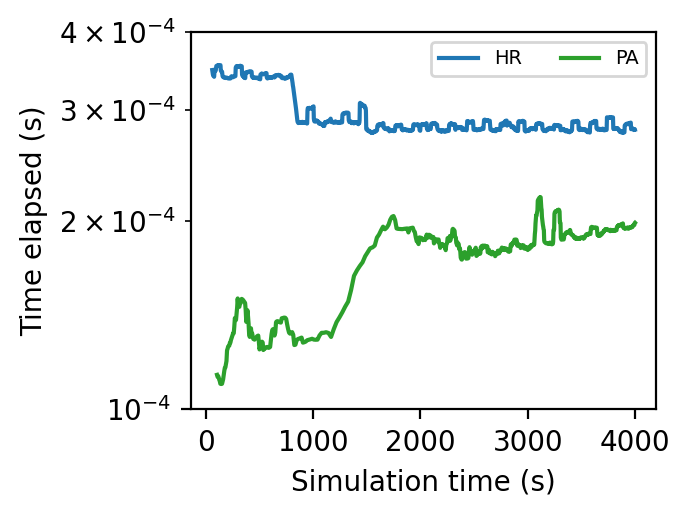

In [177]:
# Visualize the results
rolling_window = 20
sigma = 2
hr_df = hr_logger.to_dataframe().set_index("t")
hr_rolling = hr_df.time_elapsed.rolling(rolling_window)
hr_rmean = hr_rolling.mean()

pa_df = pa_logger.to_dataframe().set_index("t")
pa_rolling = pa_df.time_elapsed.rolling(rolling_window)
pa_rmean = pa_rolling.mean()

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
time_range = (hr_df.index[0], hr_df.index[-1])

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(pa_rmean, color="C2", label="PA")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([1e-4, 4e-4])
save_fig(fig, "polymorphic_transformation_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

In [181]:
pa_logger, hr_logger = polymorphic_transformation_profiling(kd=np.array([-0.2, -0.1]))

HR Mean: 0.00034063150182884696
PA Mean: 0.00014682126243843773


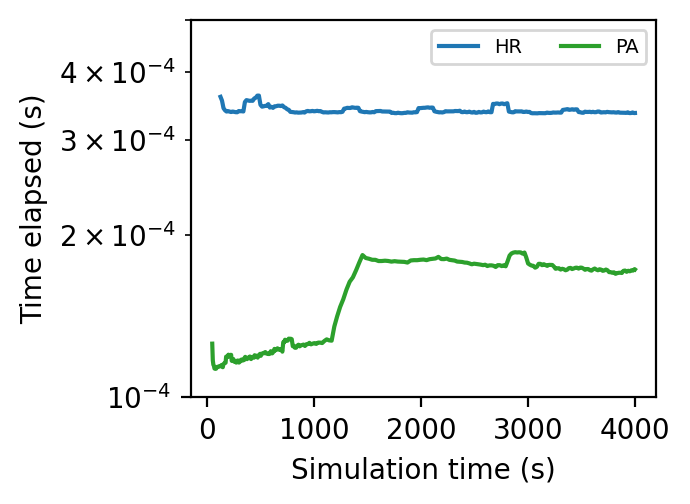

In [182]:
# Visualize the results
rolling_window = 10
sigma = 2
hr_df = hr_logger.to_dataframe().set_index("t")
hr_rolling = hr_df.time_elapsed.rolling(rolling_window)
hr_rmean = hr_rolling.mean()

pa_df = pa_logger.to_dataframe().set_index("t")
pa_rolling = pa_df.time_elapsed.rolling(rolling_window)
pa_rmean = pa_rolling.mean()

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
time_range = (hr_df.index[0], hr_df.index[-1])

ax.plot(hr_rmean, color="C0", label="HR")
ax.plot(pa_rmean, color="C2", label="PA")

ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([1e-4, 5e-4])
save_fig(fig, "polymorphic_transformation_profiling")

print(f"HR Mean: {hr_df.time_elapsed.mean()}")
print(f"PA Mean: {pa_df.time_elapsed.mean()}")

# Agglomeration and breakage

## 1D Agglomeration - Linear size grid

In [64]:
grid_logger = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()

L_edges = np.linspace(0, 10, 300)
L_centers = 0.5 * (L_edges[1:] + L_edges[:-1])

N0 = 1e11
L0 = 1.5

z = L_centers / L0

dt = 1.
t_total = 320.
kernel_coef = 6e-13

n_init = N0/L0 * z**2 * np.exp(-z**3)

n = n_init.copy()
t = 0
while t < t_total:
    grid_logger.before()
    B, D = agglomeration_grid_1d(n, L_edges, L_centers, kernel_coef, aggl_dim_power=3)
    n += (B - D) * dt
    t += dt
    grid_logger.after({"t": t})

N = np.vstack([L_centers, n_init*np.diff(L_edges)]).T
N = N[N[:, -1] > 0]

t = 0
while t < t_total:
    pac_logger.before()
    B, D = agglomeration_pa_1d(N, kernel_coef, dim_powers=np.array([3.]), min_count=1e-3, aggl_dim=0)
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, 0.1, np.array([3]), 1, False)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})


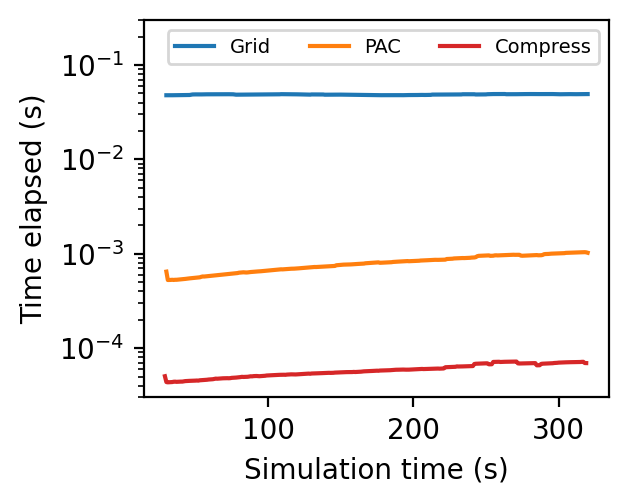

In [79]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

grid_rmean, grid_df = get_rolling_mean(grid_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_rmean, color="C0", label="Grid")
ax.plot(pac_rmean, color="C1", label="PAC")
ax.plot(c_rmean, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.3e-4, 30e-2])
save_fig(fig, "1d_agglomeration_linear_size_profiling")

## 1D Agglomeration - Log volume grid


In [83]:
grid_logger = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()

v_edges = np.logspace(-5, 9, 300)
v_centers = 0.5 * (v_edges[1:] + v_edges[:-1])

N0 = 1e0
v0 = 1.0

z = v_centers / v0

dt = 1
t_total = 300
kernel_coef = 1e-2

n_init = N0 * v_centers/v0 * np.exp(-v_centers/v0)

M0 = 2*N0 / (2 + kernel_coef * N0 * t_total)
T = 1 -  M0/ N0
n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)


n = n_init.copy()

t = 0

while t < t_total:
    grid_logger.before()
    B, D = agglomeration_grid_1d(n, v_edges, v_centers, kernel_coef, aggl_dim_power=1, min_count=1e-16)
    n += (B - D) * dt
    t += dt
    grid_logger.after({"t": t})



N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 1e-16]

t = 0
while t < t_total:
    pac_logger.before()
    B, D = agglomeration_pa_1d(N, kernel_coef, dim_powers=np.array([1.]), min_count=1e-16)
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, 0.1, np.array([1]), 1., True)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})

<ipython-input-83-83dded1b2043>:21: RuntimeWarning: overflow encountered in sinh
  n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)
<ipython-input-83-83dded1b2043>:21: RuntimeWarning: invalid value encountered in multiply
  n_final = N0 *(1-T)**2 / (v0* T**0.5) * np.exp(-v_centers/v0) * np.sinh(v_centers/v0*T**0.5)


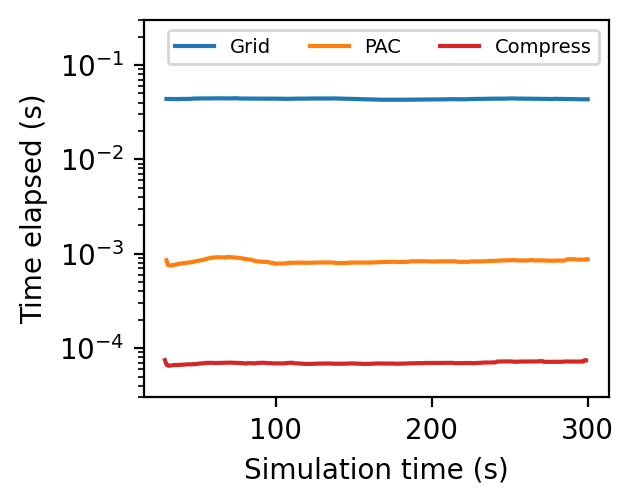

In [85]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

grid_rmean, grid_df = get_rolling_mean(grid_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_rmean, color="C0", label="Grid")
ax.plot(pac_rmean, color="C1", label="PAC")
ax.plot(c_rmean, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.3e-4, 30e-2])
save_fig(fig, "1d_agglomeration_log_vol_profiling")

## Breakage 1D (squared-volume kernel)

In [104]:
grid_logger = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()

v_edges = np.logspace(-5, 0, 400)
v_centers = log_mean(v_edges)
n_init = np.zeros_like(v_centers)
n_init[-1] = 1 / (v_edges[-1] - v_edges[-2])

kernel_coef =1e0
t_total = 10
dt = 0.01


n = n_init.copy()

t = 0
while t < t_total:
    grid_logger.before()
    B, D = breakage_grid_1d(n, v_edges, v_centers, kernel_coef)
    n += (B - D) * dt
    t += dt
    grid_logger.after({"t": t})


N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 0]

t = 0
while t < t_total:
    pac_logger.before()
    B, D = breakage_pa_1d(N, kernel_coef, kernel_type=BreakageKernel.SQUARE)
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, 0.1, np.array([1]), 1, True)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})


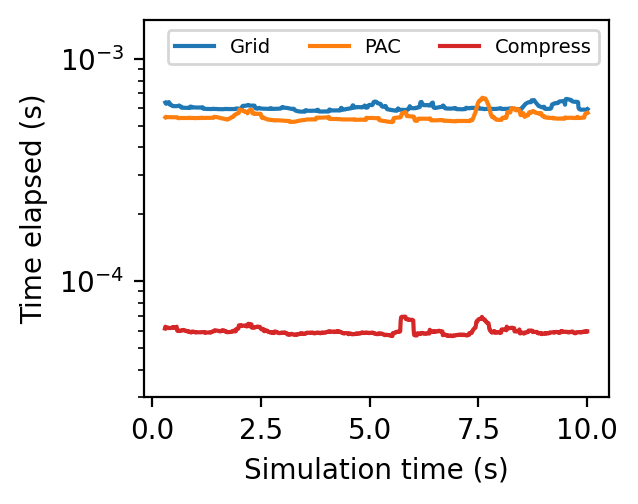

In [105]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

grid_rmean, grid_df = get_rolling_mean(grid_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_rmean, color="C0", label="Grid")
ax.plot(pac_rmean, color="C1", label="PAC")
ax.plot(c_rmean, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.3e-4, 15e-4])
save_fig(fig, "1d_breakage_squared_kernel_profiling")

## Breakage 1D (linear-volume kernel)

In [100]:
grid_logger = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()


v_edges = np.logspace(-5, 0, 400)
v_centers = log_mean(v_edges)

n_init = np.zeros_like(v_centers)
n_init[-1] = 1 / (v_edges[-1] - v_edges[-2])

kernel_coef =1e0
t_total = 10
dt = 0.01

n = n_init.copy()

t = 0
while t < t_total:
    grid_logger.before()
    B, D = breakage_grid_1d(n, v_edges, v_centers, kernel_coef, kernel_type=BreakageKernel.LINEAR)
    n += (B - D) * dt
    t += dt
    grid_logger.after({"t": t})


N = np.vstack([v_centers, n_init*np.diff(v_edges)]).T
N = N[N[:, -1] > 0]

t = 0
while t < t_total:
    pac_logger.before()
    B, D = breakage_pa_1d(N, kernel_coef, kernel_type=BreakageKernel.LINEAR)
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, 0.1, np.array([1]), 1, True)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})


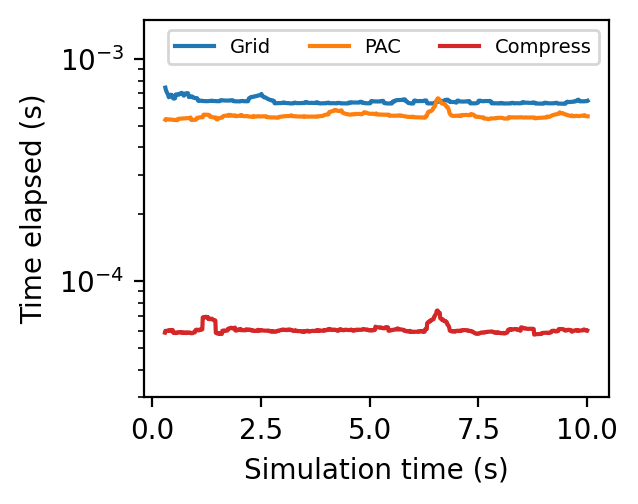

In [103]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

grid_rmean, grid_df = get_rolling_mean(grid_logger, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_rmean, color="C0", label="Grid")
ax.plot(pac_rmean, color="C1", label="PAC")
ax.plot(c_rmean, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=3)
ax.set_ylim([0.3e-4, 15e-4])
save_fig(fig, "1d_breakage_linear_kernel_profiling")

## Agglomeration 2D

In [118]:
grid_logger_20 = PerformanceLogger()
grid_logger_40 = PerformanceLogger()
pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()

######### 20
L_edges_0 = np.arange(0, 20, 0.5)
L_edges_1 = np.arange(0, 20, 0.5)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0]) 

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(z, loc=0, scale=3)

dt = 0.1
t_total = 10.
kernel_coef = np.array([1., 1.])
aggl_powers = np.array([2., 1.])


n = n_init.copy()

cnts = [(n * L_edge_diff_area).sum()]
vols = [(n * Lc0**2 * Lc1 * L_edge_diff_area).sum()]
t = 0
while t < t_total:
    grid_logger_20.before()
    B, D = agglomeration_grid_2d(n, L_edges, L_centers, kernel_coef, aggl_powers, min_count=1e-18)
    n += (B - D) * dt
    t += dt
    grid_logger_20.after({"t": t})
    
######### 40
L_edges_0 = np.arange(0, 40, 0.5)
L_edges_1 = np.arange(0, 40, 0.5)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0]) 

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(z, loc=0, scale=3)

dt = 0.1
t_total = 10.
kernel_coef = np.array([1., 1.])
aggl_powers = np.array([2., 1.])

n = n_init.copy()

cnts = [(n * L_edge_diff_area).sum()]
vols = [(n * Lc0**2 * Lc1 * L_edge_diff_area).sum()]
t = 0
while t < t_total:
    grid_logger_40.before()
    B, D = agglomeration_grid_2d(n, L_edges, L_centers, kernel_coef, aggl_powers, min_count=1e-18)
    n += (B - D) * dt
    t += dt
    grid_logger_40.after({"t": t})
    
    
####### PA

N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0]
N_init = N.copy()
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [0]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
pa_d = [0]
ginterval = 0.5
N = compress(N, ginterval, aggl_powers, 1, )

while t < t_total:
    pac_logger.before()
    v_original = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    Bs, D = agglomeration_pa_2d(N, (0.3, 0.3), kernel_coef, aggl_powers, min_count=1e-9)
    B = np.vstack(Bs)
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    
    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, ginterval, aggl_powers, 1, False)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})

<ipython-input-118-616990deed1b>:69: RuntimeWarning: invalid value encountered in subtract
  n += (B - D) * dt
<ipython-input-118-616990deed1b>:69: RuntimeWarning: invalid value encountered in add
  n += (B - D) * dt


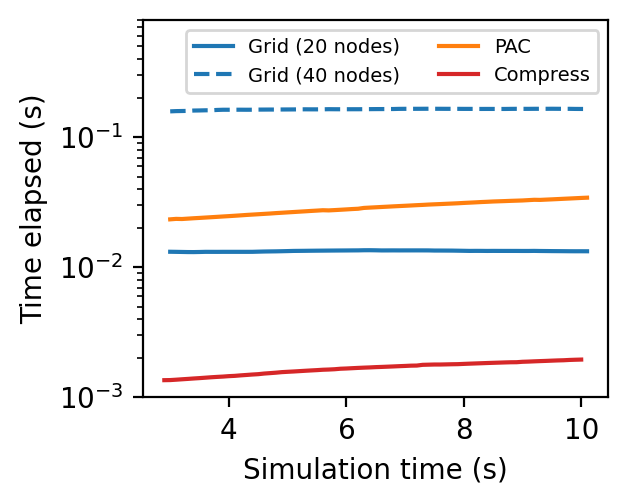

In [121]:
# Visualize results
# Visualize the results
rolling_window = 30
sigma = 2

grid_rmean_20, grid_df_20 = get_rolling_mean(grid_logger_20, rolling_window)
grid_rmean_40, grid_df_40 = get_rolling_mean(grid_logger_40, rolling_window)
pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_rmean_20, color="C0", label="Grid (20 nodes)")
ax.plot(grid_rmean_40, "C0--", label="Grid (40 nodes)")
ax.plot(pac_rmean, color="C1", label="PAC")
ax.plot(c_rmean, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=2)
ax.set_ylim([0.1e-2, 8e-1])
save_fig(fig, "2d_agglomeration_profiling")

## Breakage 2D

In [267]:
grid_logger_50 = PerformanceLogger()
grid_logger_25 = PerformanceLogger()

pac_logger = PerformanceLogger()
compress_logger = PerformanceLogger()


####### 50
L_edges_0 = np.linspace(0, 10, 51)
L_edges_1 = np.linspace(0, 10, 50)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0])

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(Lc0, loc=8, scale=3) * norm.pdf(Lc1, loc=8, scale=3)

dt = 1.
t_total = 30.
kernel_coef = np.array([1e-7, 1e-7])
brk_powers = np.array([2., 1.])

t = 0
n = n_init.copy()
cnt = (n * L_edge_diff_area).sum()
vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()

while t < t_total:
    grid_logger_50.before()
    B, D = breakage_grid_2d(n, L_edges, L_centers, kernel_coef, brk_powers)
    n += (B - D) * dt
    t += dt
    grid_logger_50.after({"t": t})

####### 25
L_edges_0 = np.linspace(0, 10, 25)
L_edges_1 = np.linspace(0, 10, 25)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0])

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(Lc0, loc=8, scale=3) * norm.pdf(Lc1, loc=8, scale=3)

dt = 1.
t_total = 30.
kernel_coef = np.array([1e-7, 1e-7])
brk_powers = np.array([2., 1.])

t = 0
n = n_init.copy()
cnt = (n * L_edge_diff_area).sum()
vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()

while t < t_total:
    grid_logger_25.before()
    B, D = breakage_grid_2d(n, L_edges, L_centers, kernel_coef, brk_powers)
    n += (B - D) * dt
    t += dt
    grid_logger_25.after({"t": t})    
####### PA
    
N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0*L_edge_diff_area]
N_init = N.copy()
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [t]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
while t < t_total:
    pac_logger.before()
    Bs, D = breakage_pa_2d(N, kernel_coefs=kernel_coef, dim_powers=brk_powers, min_count=1e-15, daughter_grid_type=DaughterGridType.LINEAR)
    B = np.vstack(Bs)
    N[:, -1] -= dt * D
    B[:, -1] *= dt

    N = np.vstack((N, B))
    compress_logger.before()
    N = compress_native(N, 1.0, brk_powers, 1, False)
    compress_logger.after({"t": t})
    t += dt
    pac_logger.after({"t": t})

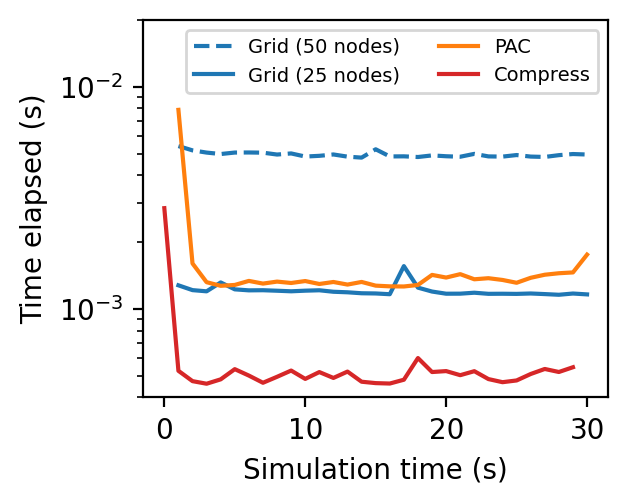

In [269]:
# Visualize results
# Visualize the results
rolling_window = 3
sigma = 2

grid_rmean_50, grid_df_50 = get_rolling_mean(grid_logger_50, rolling_window)
grid_rmean_25, grid_df_25 = get_rolling_mean(grid_logger_25, rolling_window)

pac_rmean, pac_df = get_rolling_mean(pac_logger, rolling_window)
c_rmean, c_df = get_rolling_mean(compress_logger, rolling_window)

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.plot(grid_df_50, "C0--", label="Grid (50 nodes)")
ax.plot(grid_df_25, "C0", label="Grid (25 nodes)")
ax.plot(pac_df, color="C1", label="PAC")
ax.plot(c_df, "C3", label="Compress")


ax.set_yscale("log")
ax.set_xlabel("Simulation time (s)")
ax.set_ylabel("Time elapsed (s)")
ax.legend(loc="upper right", fontsize=font_size, ncol=2)
ax.set_ylim([0.4e-3, 2e-2])
save_fig(fig, "2d_breakage_profiling")

# Compression vs rows

In [195]:
nrows = np.logspace(0, 6, 50, dtype=np.int64)
repeat = 6
interval = 0.5
ws = np.array([3.,])
kshape = 1.
def timing(func, nrow, repeat=repeat, ):
    exec_times = []
    for i in range(repeat):
        begin = perf_counter()
        func()
        end = perf_counter()
        exec_times.append({"repeat": i, "time": end-begin, "nrow":nrow})
    return exec_times


In [251]:
compression_speed = []
compression_native_speed = []
for nrow in nrows:
    N = np.random.random((nrow, 2))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    
    r = timing(lambda: compress(N, interval, ws, kshape), nrow)
    compression_speed.extend(r)
    
    r = timing(lambda: compress_native(N, interval, ws, kshape, False), nrow)
    compression_native_speed.extend(r)

In [250]:
compression_native_speed_2d = []
for nrow in nrows:
    N = np.random.random((nrow, 3))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    N[:, 1] *= 10
    
    r = timing(lambda: compress_native(N, interval, ws, kshape, False), nrow)
    compression_native_speed_2d.extend(r)

In [249]:
growth_speed = []
for nrow in nrows:
    N = np.random.random((nrow, 2))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    g = np.array([0.1])
    
    r = timing(lambda: pa_forward_step(N, 1.0, g), nrow)
    growth_speed.extend(r)

In [276]:
nucleation_speed = []
for nrow in nrows:
    N = np.random.random((nrow, 2))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    g = np.array([0.1])
    
    r = timing(lambda: np.vstack([N, np.array([1., 10000.])]), nrow)
    nucleation_speed.extend(r)

In [256]:
nrows_agg_brk = np.logspace(0, 3, 15, dtype=np.int64)
aggl_1d_speed = []
brk_1d_speed = []
aggl_2d_speed = []
brk_2d_speed = []
for nrow in tqdm(nrows_agg_brk):
    N = np.random.random((nrow, 2))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    
    r = timing(lambda: agglomeration_pa_1d(N, 1.0, np.array([3.]), ), nrow)
    aggl_1d_speed.extend(r)
    
    r = timing(lambda: breakage_pa_1d(N, 1.0, dim_powers=np.array([3.]), ), nrow)
    brk_1d_speed.extend(r)
    
    N = np.random.random((nrow, 2))
    N[:, -1] *= 1e5
    N[:, 0] *= 10
    N[:, 1] *= 10
    
    r = timing(lambda: agglomeration_pa_2d(N, (2., 2.), np.array([1., 1.]), np.array([2.0, 1.0])), nrow, repeat=3)
    aggl_2d_speed.extend(r)
    
    r = timing(lambda: breakage_pa_2d(N, np.array([1., 1.]), dim_powers=np.array([2., 1.]), ), nrow, repeat=3)
    brk_2d_speed.extend(r)

  0%|          | 0/15 [00:00<?, ?it/s]

In [278]:
from scipy import stats

def get_result_df(speed):
    df = pd.DataFrame.from_dict(speed)
    
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
    groupby = df.groupby("nrow")
    median = groupby.time.apply(lambda x: x[np.abs(stats.zscore(x)) < 3].median())
    mean = groupby.time.apply(lambda x: x[np.abs(stats.zscore(x)) < 3].mean())
    std = groupby.time.apply(lambda x: x[np.abs(stats.zscore(x)) < 3].std())
    
    return median, mean, std, df

compress_results = get_result_df(compression_speed)
compress_native_results = get_result_df(compression_native_speed)
compress_native_2d_results = get_result_df(compression_native_speed_2d)

aggl_1d_results = get_result_df(aggl_1d_speed)
aggl_2d_results = get_result_df(aggl_2d_speed)
brk_1d_results = get_result_df(brk_1d_speed)
brk_2d_results = get_result_df(brk_2d_speed)

growth_results = get_result_df(growth_speed)
nucleation_results = get_result_df(nucleation_speed)

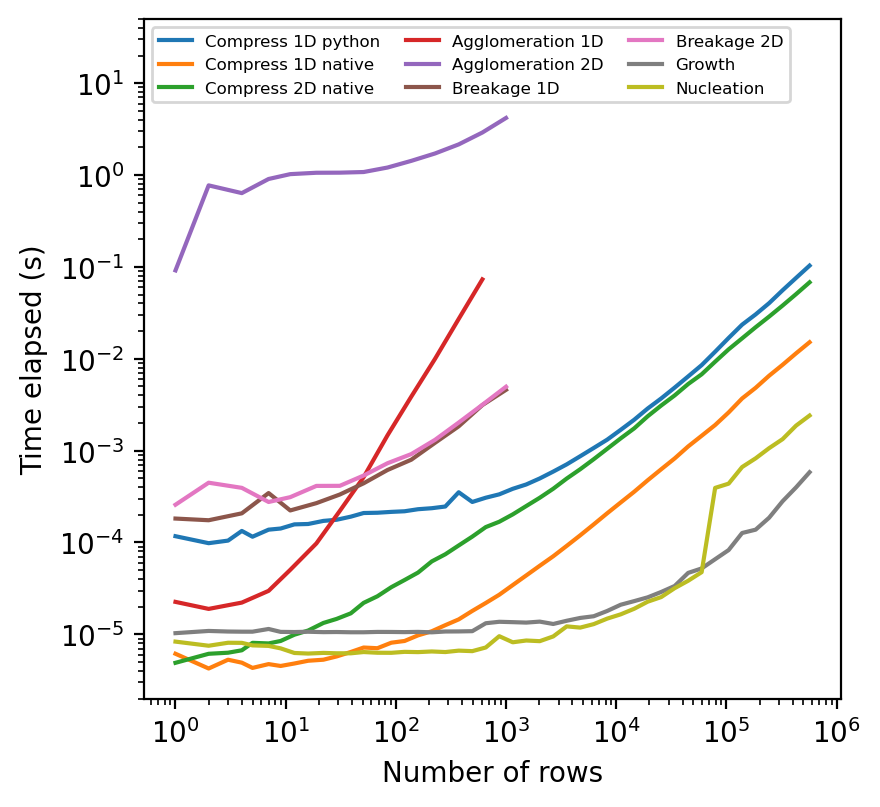

In [282]:
fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=200)
ax.plot(compress_results[1], "C0", label="Compress 1D python")
ax.plot(compress_native_results[1], "C1", label="Compress 1D native")
ax.plot(compress_native_2d_results[1], "C2", label="Compress 2D native")

ax.plot(aggl_1d_results[1], "C3", label="Agglomeration 1D")
ax.plot(aggl_2d_results[1], "C4", label="Agglomeration 2D")
ax.plot(brk_1d_results[1], "C5", label="Breakage 1D")
ax.plot(brk_2d_results[1], "C6", label="Breakage 2D")


ax.plot(growth_results[1], "C7", label="Growth")
ax.plot(nucleation_results[1], "C8", label="Nucleation")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper left", fontsize=6, ncol=3, columnspacing=1.5)
ax.set_xlabel("Number of rows")
ax.set_ylabel("Time elapsed (s)")
ax.set_ylim([2e-6, 0.5e2])
save_fig(fig, "pa_overall_profiling")